<a href="https://colab.research.google.com/github/khaireddine-satouri/10-Applied-Data-Science-Capstone/blob/main/TransformerEncoderDecoder_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EncoderDecoder First Version
Standard Transformer implementation respectly to the paper "**Attention is all you need**"
Idea of Exactly implementation of all the classic architecture of the transformer with Encoder and Decoder  
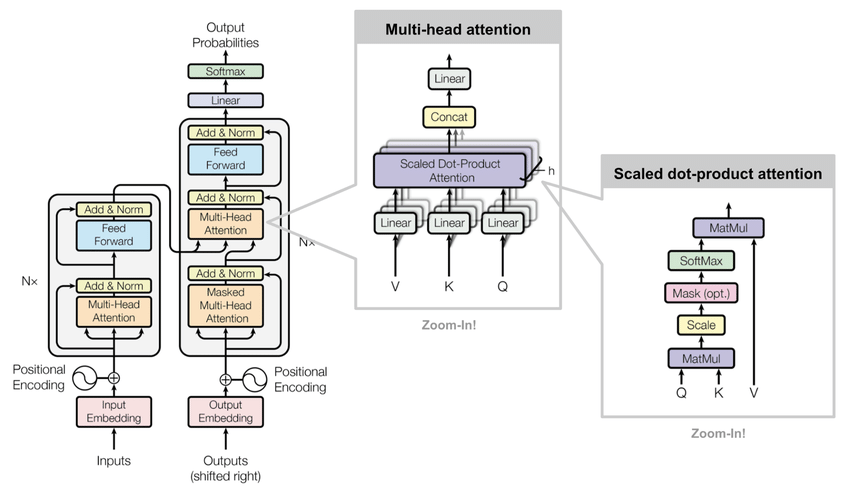

## Multi-head attention

L'attention multi-têtes est un élément clé de l'architecture du transformateur, car elle permet au modèle de capturer différents types d'informations à partir de différentes parties de la séquence d'entrée.
*   La classe **MultiHeadAttention** est une implémentation de l'attention multi-têtes qui est une technique pour permettre au modèle de se concentrer sur différentes parties d'une séquence simultanément.
*   Dans le constructeur **__init__**, nous définissons les poids (Dense layers) pour les requêtes, clés et valeurs, ainsi qu'un autre Dense layer pour la sortie.
*   La méthode **split_heads** est utilisée pour diviser les entrées en plusieurs "têtes". Cela permet au modèle de traiter l'information de manière parallèle.
*   Dans la méthode **call**, nous transformons d'abord les entrées à l'aide des poids définis, puis nous divisons les entrées en plusieurs têtes. Ensuite, nous calculons les logits d'attention, les mettons à l'échelle, appliquons éventuellement un masque, puis utilisons softmax pour obtenir les poids d'attention. Enfin, nous utilisons ces poids pour obtenir la sortie de l'attention et concaténons les têtes pour obtenir la sortie finale.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Embedding
from tensorflow.keras.models import Model

# La classe MultiHeadAttention hérite de la classe Layer de Keras.
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # Nombre de têtes d'attention.
        self.d_model = d_model  # Dimension du modèle.

        # Assurez-vous que la dimension du modèle est divisible par le nombre de têtes.
        assert d_model % self.num_heads == 0

        # Profondeur de chaque tête.
        self.depth = d_model // self.num_heads

        # Ces poids sont utilisés pour transformer les entrées pour l'attention.
        self.wq = Dense(d_model)  # Poids pour la requête.
        self.wk = Dense(d_model)  # Poids pour la clé.
        self.wv = Dense(d_model)  # Poids pour la valeur.

        # Dense layer utilisé après la concaténation des têtes d'attention.
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Divise la dernière dimension en (num_heads, depth).
        Transpose le résultat de manière à ce que la forme soit (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Transformation des entrées à l'aide des poids définis.
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Divisez les entrées en plusieurs têtes.
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Mécanisme d'attention.
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        # Si un masque est fourni, ajoutez-le aux logits.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Appliquez softmax pour obtenir les poids d'attention.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        # Post-traitement pour concaténer les têtes.
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

#  feed-forward

La couche feed-forward agit comme un transformateur pour les représentations obtenues à partir de la couche d'attention multi-têtes, permettant au modèle d'apprendre des interactions non linéaires entre les caractéristiques.  

*   La classe **FeedForward** est une implémentation d'un réseau feed-forward simple composé de deux couches denses. C'est une partie standard de l'architecture du transformateur, utilisée après la couche d'attention multi-têtes dans les blocs d'encodeur et de décodeur.

*   Dans le constructeur **__init__**, deux couches denses sont définies :
1.   **self.fc1** est la première couche dense avec une activation **ReLU**. Elle transforme l'entrée à une dimension **dff**, qui est généralement plus grande que **d_model**. Cela permet au modèle d'apprendre des représentations plus complexes.
2.   **self.fc2** est la deuxième couche dense qui ramène la dimension de sortie à **d_model**.  
*   Dans la méthode **call**, l'entrée **x** est passée à travers les deux couches denses séquentiellement.

In [2]:
# La classe FeedForward hérite de la classe Layer de Keras.
class FeedForward(Layer):
    def __init__(self, d_model, dff):
        """
        d_model: la dimension de l'embedding
        dff: la dimension de la couche interne (dimension de la couche cachée)
        """
        super(FeedForward, self).__init__()

        # Première couche dense avec une activation ReLU.
        self.fc1 = Dense(dff, activation='relu')
        # Deuxième couche dense sans activation.
        self.fc2 = Dense(d_model)

    def call(self, x):
        # Passez l'entrée à travers la première couche dense.
        x = self.fc1(x)
        # Passez le résultat à travers la deuxième couche dense.
        x = self.fc2(x)
        return x


# Encoder Layer

Chaque couche d'encodeur est composée de deux sous-couches principales : une attention multi-têtes et un réseau feed-forward.  
1. Dans le constructeur **__init__** :
*   **self.mha** est une instance de la classe MultiHeadAttention que nous avons déjà discutée.
*   **self.ffn** est une instance de la classe FeedForward.
*   **self.layernorm1** et self.layernorm2 sont des instances de la normalisation de couche, qui est utilisée pour stabiliser les activations dans le modèle.
*   **self.dropout1** et **self.dropout2** sont des instances de dropout, utilisées pour la régularisation.
2. Dans la méthode **call** :
*   La première sous-couche est l'attention multi-têtes. L'entrée x est passée à travers cette attention (en tant que q, k, et v), suivie d'un dropout et d'une connexion résiduelle. La sortie est ensuite normalisée.
*   La deuxième sous-couche est le réseau feed-forward. La sortie de la première sous-couche est passée à travers ce réseau, suivie d'un dropout et d'une connexion résiduelle. La sortie est ensuite normalisée.

Les connexions résiduelles sont essentielles pour permettre un entraînement efficace des transformateurs profonds, car elles aident à éviter le problème du gradient qui s'évanouit. La normalisation de couche est également cruciale pour stabiliser les activations et accélérer la convergence.


In [3]:
# La classe EncoderLayer hérite de la classe Layer de Keras.
class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """
        d_model: la dimension de l'embedding
        num_heads: le nombre de têtes d'attention
        dff: la dimension de la couche interne (dimension de la couche cachée)
        rate: taux de dropout
        """
        super(EncoderLayer, self).__init__()

        # Attention multi-têtes
        self.mha = MultiHeadAttention(d_model, num_heads)
        # Réseau feed-forward
        self.ffn = FeedForward(d_model, dff)

        # Normalisation de couche pour stabiliser les activations
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        # Dropout pour la régularisation
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask=None):
        # Sous-couche 1: Attention multi-têtes
        attn_output, _ = self.mha(x, x, x, mask)  # Auto-attention: q, k, v sont tous x
        attn_output = self.dropout1(attn_output, training=training)
        # Connexion résiduelle suivie d'une normalisation de couche
        out1 = self.layernorm1(x + attn_output)

        # Sous-couche 2: Réseau feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Connexion résiduelle suivie d'une normalisation de couche
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Decoder Layer

Chaque couche de décodeur est composée de trois sous-couches principales : une attention multi-têtes (avec masquage), une attention multi-têtes qui prend la sortie de l'encodeur, et un réseau feed-forward.
1. Dans le constructeur **__init__** :
*  **self.mha1** est la première instance de la classe **MultiHeadAttention** pour le décodeur. Elle est utilisée pour l'auto-attention avec masquage.
*  **self.mha2** est la deuxième instance de la classe MultiHeadAttention qui prend la sortie de l'encodeur.
*  **self.ffn** est une instance de la classe FeedForward.
*  **self.layernorm1**, **self.layernorm2**, et **self.layernorm3** sont des instances de la normalisation de couche.
*  **self.dropout1**, **self.dropout2**, et **self.dropout3** sont des instances de dropout.
2. Dans la méthode **call** :
*  La première sous-couche est l'attention multi-têtes avec masquage. L'entrée **x** est passée à travers cette attention (en tant que q, k, et v), suivie d'un dropout et d'une connexion résiduelle. La sortie est ensuite normalisée.
*  La deuxième sous-couche est l'attention multi-têtes qui prend la sortie de l'encodeur. La sortie de la première sous-couche et la sortie de l'encodeur sont passées à travers cette attention, suivie d'un dropout et d'une connexion résiduelle. La sortie est ensuite normalisée.
*  La troisième sous-couche est le réseau feed-forward. La sortie de la deuxième sous-couche est passée à travers ce réseau, suivie d'un dropout et d'une connexion résiduelle. La sortie est ensuite normalisée.  

Comme pour l'encodeur, les connexions résiduelles et la normalisation de couche sont essentielles pour permettre un entraînement efficace des transformateurs profonds.


In [4]:
# La classe DecoderLayer hérite de la classe Layer de Keras.
class DecoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """
        d_model: la dimension de l'embedding
        num_heads: le nombre de têtes d'attention
        dff: la dimension de la couche interne (dimension de la couche cachée)
        rate: taux de dropout
        """
        super(DecoderLayer, self).__init__()

        # Première attention multi-têtes pour le décodeur (avec masquage).
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # Deuxième attention multi-têtes qui prend la sortie de l'encodeur.
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        # Réseau feed-forward.
        self.ffn = FeedForward(d_model, dff)

        # Normalisation de couche pour stabiliser les activations.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        # Dropout pour la régularisation.
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # Sous-couche 1: Attention multi-têtes avec masquage.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)  # Connexion résiduelle suivie d'une normalisation de couche.

        # Sous-couche 2: Attention multi-têtes avec la sortie de l'encodeur.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # Connexion résiduelle suivie d'une normalisation de couche.

        # Sous-couche 3: Réseau feed-forward.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # Connexion résiduelle suivie d'une normalisation de couche.

        return out3, attn_weights_block1, attn_weights_block2

# Positional encoding

Positional encoding est une technique utilisée dans l'architecture du transformateur pour donner un sens à la position des mots dans une séquence, car le transformateur lui-même ne possède pas de notion inhérente de la position des mots (contrairement aux RNN ou LSTM). Le codage positionnel est ajouté aux embeddings des mots pour fournir cette information de position.  
*  La fonction **get_angles** calcule les taux d'angle pour le codage positionnel. Ces taux sont basés sur une décroissance exponentielle, où la base de l'exponentielle est 10000. La raison de cette décroissance est de permettre au modèle de distinguer facilement les positions des mots dans la séquence.
*  La fonction **positional_encoding** utilise les taux d'angle pour calculer le codage positionnel réel. Pour chaque dimension de l'embedding, le codage positionnel est soit le sinus soit le cosinus de la position du mot dans la séquence, multiplié par le taux d'angle. Les dimensions paires utilisent le sinus, et les dimensions impaires utilisent le cosinus.  

En combinant ces sinus et cosinus à différentes fréquences, le transformateur peut apprendre à utiliser ces informations pour déterminer la position relative des mots dans la séquence.

In [5]:
def get_angles(pos, i, d_model):
    """
    Calcule les taux d'angle pour le codage positionnel.

    Args:
    - pos: La position du mot dans la séquence.
    - i: La dimension de l'embedding.
    - d_model: La dimension totale de l'embedding.

    Returns:
    - Les taux d'angle pour le codage positionnel.
    """
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    Calcule le codage positionnel pour une position donnée.

    Args:
    - position: La position du mot dans la séquence.
    - d_model: La dimension totale de l'embedding.

    Returns:
    - Le codage positionnel pour la position donnée.
    """
    # Calcule les taux d'angle pour le codage positionnel.
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # Appliquer le sinus aux indices pairs de la matrice (2i).
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Appliquer le cosinus aux indices impairs de la matrice (2i+1).
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # Ajoute une dimension supplémentaire pour correspondre à la forme d'entrée et convertit en tensor TensorFlow.
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


# l'Encodeur

Encoder représente l'encodeur complet de l'architecture du transformateur. L'encodeur est composé de plusieurs couches d'encodeur (comme défini dans la classe **EncoderLayer** précédemment discutée).  
1. Dans le constructeur __init__ :
*  **self.embedding** est une couche d'embedding qui convertit les indices de mots en vecteurs denses de dimension d_model.
*  **self.pos_encoding** est l'encodage positionnel calculé pour une séquence de taille **maximum_position_encoding**. Il est ajouté aux embeddings pour fournir des informations sur la position des mots dans la séquence.
*  **self.enc_layers** est une liste de couches d'encodeur. Chaque couche est une instance de la classe EncoderLayer.
self.dropout est une couche de dropout utilisée pour la régularisation.
2. Dans la méthode call :
*  L'entrée **x** est d'abord convertie en embeddings.
*  Les embeddings sont mis à l'échelle par la racine carrée de **d_model** (c'est une particularité des transformateurs pour aider à la stabilité).
*  L'encodage positionnel est ajouté aux embeddings.
*  Le dropout est appliqué.
*  L'entrée est ensuite passée à travers chaque couche d'encodeur dans self.enc_layers.  

L'encodeur transforme l'entrée (une séquence de mots) en une représentation continue qui est ensuite utilisée par le décodeur pour générer la sortie.

In [6]:
# La classe Encoder hérite de la classe Layer de Keras.
class Encoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        """
        Args:
        - num_layers: Nombre de couches d'encodeur.
        - d_model: Dimension de l'embedding.
        - num_heads: Nombre de têtes d'attention.
        - dff: Dimension de la couche interne (dimension de la couche cachée).
        - input_vocab_size: Taille du vocabulaire en entrée (pour l'embedding).
        - maximum_position_encoding: Taille maximale de la séquence pour l'encodage de position.
        - rate: Taux de dropout.
        """
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding pour convertir les indices de mots en vecteurs denses.
        self.embedding = Embedding(input_vocab_size, d_model)
        # Encodage positionnel pour ajouter des informations sur la position des mots dans la séquence.
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Empilement des couches d'encodeur.
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        # Dropout pour la régularisation.
        self.dropout = Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Conversion des indices de mots en embeddings.
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        # Mise à l'échelle des embeddings.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Ajout de l'encodage positionnel.
        x += self.pos_encoding[:, :seq_len, :]

        # Application du dropout.
        x = self.dropout(x, training=training)

        # Passage de l'entrée à travers chaque couche d'encodeur.
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, seq_len, d_model)

# Le Decodeur

La classe Decoder représente le décodeur complet de l'architecture du transformateur. Le décodeur est composé de plusieurs couches de décodeur (comme défini dans la classe **DecoderLayer** précédemment discutée).  
1. Dans le constructeur **__init__** :
*  **self.embedding** est une couche d'embedding qui convertit les indices de mots en vecteurs denses de dimension **d_model**.
*  **self.pos_encoding** est l'encodage positionnel calculé pour une séquence de taille **maximum_position_encoding**.
*  **self.dec_layers** est une liste de couches de décodeur. Chaque couche est une instance de la classe DecoderLayer.
*  **self.dropout** est une couche de dropout utilisée pour la régularisation.
2. Dans la méthode **call** :
*  L'entrée **x** est d'abord convertie en embeddings.
*  Les embeddings sont mis à l'échelle par la racine carrée de **d_model**.
*  L'encodage positionnel est ajouté aux embeddings.
*  Le dropout est appliqué.
*  L'entrée est ensuite passée à travers chaque couche de décodeur dans **self.dec_layers**.
*  Les poids d'attention de chaque couche sont stockés dans le dictionnaire **attention_weights** pour une éventuelle visualisation ou analyse.  

Le décodeur transforme la représentation continue obtenue de l'encodeur en une séquence de sortie, généralement utilisée pour la génération de texte ou la traduction.

In [7]:
# La classe Decoder hérite de la classe Layer de Keras.
class Decoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        """
        Args:
        - num_layers: Nombre de couches de décodeur.
        - d_model: Dimension de l'embedding.
        - num_heads: Nombre de têtes d'attention.
        - dff: Dimension de la couche interne (dimension de la couche cachée).
        - target_vocab_size: Taille du vocabulaire cible (pour l'embedding).
        - maximum_position_encoding: Taille maximale de la séquence pour l'encodage de position.
        - rate: Taux de dropout.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding pour convertir les indices de mots en vecteurs denses.
        self.embedding = Embedding(target_vocab_size, d_model)
        # Encodage positionnel pour ajouter des informations sur la position des mots dans la séquence.
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Empilement des couches de décodeur.
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        # Dropout pour la régularisation.
        self.dropout = Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Conversion des indices de mots en embeddings.
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        # Mise à l'échelle des embeddings.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Ajout de l'encodage positionnel.
        x += self.pos_encoding[:, :seq_len, :]

        # Application du dropout.
        x = self.dropout(x, training=training)

        # Passage de l'entrée à travers chaque couche de décodeur.
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # Stockage des poids d'attention pour une visualisation éventuelle.
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Transformer

La classe Transformer est le cœur de l'architecture du transformateur, combinant l'encodeur et le décodeur pour former le modèle complet.  
1.  Dans le constructeur **__init__** :
*  **self.encoder** est une instance de la classe **Encoder**.
*  **self.decoder** est une instance de la classe **Decoder**.
*  **self.final_layer** est une couche dense qui produit des logits pour chaque mot du vocabulaire cible. Ces logits sont utilisés pour calculer la probabilité de chaque mot du vocabulaire cible à chaque position de la séquence de sortie.
1. Dans la méthode **call** :
*  L'entrée est d'abord passée à travers l'encodeur pour obtenir enc_output.
*  **enc_output** (la sortie de l'encodeur) et l'entrée cible (tar) sont ensuite passées à travers le décodeur pour obtenir **dec_output**.
*  **dec_output** est finalement passé à travers self.final_layer pour obtenir les logits pour chaque mot du vocabulaire cible.  

La classe Transformer encapsule l'ensemble du processus de transformation d'une séquence d'entrée en une séquence de sortie, en utilisant l'encodeur pour encoder l'entrée en une représentation continue, et le décodeur pour transformer cette représentation en une séquence de sortie.

In [8]:
# La classe Transformer hérite de la classe Model de Keras.
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        """
        Args:
        - num_layers: Nombre de couches pour l'encodeur et le décodeur.
        - d_model: Dimension de l'embedding.
        - num_heads: Nombre de têtes d'attention.
        - dff: Dimension de la couche interne (dimension de la couche cachée).
        - input_vocab_size: Taille du vocabulaire d'entrée (pour l'embedding).
        - target_vocab_size: Taille du vocabulaire cible (pour l'embedding).
        - pe_input: Taille maximale de la séquence d'entrée pour l'encodage de position.
        - pe_target: Taille maximale de la séquence cible pour l'encodage de position.
        - rate: Taux de dropout.
        """
        super(Transformer, self).__init__()

        # Encodeur
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        # Décodeur
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        # Couche finale pour produire les logits pour chaque mot du vocabulaire cible.
        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, training=None, mask=None):
        inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask = inputs

        # Passage de l'entrée à travers l'encodeur.
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # Passage de la sortie de l'encodeur et de l'entrée cible à travers le décodeur.
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # Passage de la sortie du décodeur à travers la couche finale pour obtenir les logits.
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights